<a href="https://colab.research.google.com/github/SEC-API-io/sec-api-cookbook/blob/main/notebooks/reg-a/reg-a-tutorial-website.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Analysis of Regulation A Offering Statement Disclosures

This notebook demonstrates an exploratory data analysis examining offering statement disclosures filed under Regulation A in SEC Form 1-A, as well as subsequent updates submitted via SEC Forms 1-K and 1-Z.

Since 2015, companies have submitted Part I of these disclosures, containing notification details, in XML format. Leveraging our [Regulation A Offering Statement API](https://sec-api.io/docs/reg-a-offering-statements-api), we transform these disclosures into a standardized JSON format, facilitating comprehensive and efficient analysis.

Our analysis addresses several critical dimensions:

- Temporal trends in the number of Regulation A disclosures from 2015 to 2024, segmented by quarter, month, and intraday timing (pre-market, regular market hours, after-market).
- Distribution patterns across structured data fields, including the proportion of disclosures categorized by specific form types.
- Analysis of the offered amounts, including their distribution and temporal evolution.
- Progress tracking of offering campaigns over the reported years.
- Final aggregated metrics, including total securities sold and the corresponding completion percentages at campaign conclusion.
- Analysis of fee percentages relative to the amounts raised during offering campaigns.


## Quick Start

To quickly retrieve data for a specific company, modify the following example as needed. For more detail, see [Regulation A Offering Statement API](https://sec-api.io/docs/reg-a-offering-statements-api) and [sec-api-python package readme](https://github.com/janlukasschroeder/sec-api-python?tab=readme-ov-file#reg-a-api---offering-statements).


In [1]:
%pip install sec_api # use %pip for reliable install in current environment

In [2]:
# NOTE: Replace with your own API key
API_KEY_SEC_API = "YOUR_API_KEY"

In [3]:
from sec_api import RegASearchApi
import json

searchApi = RegASearchApi(api_key=API_KEY_SEC_API)

search_params = {
    "query": "cik:1061040",
    "from": "0",
    "size": "1",
    "sort": [{"filedAt": {"order": "desc"}}],
}

# get C filing metadata: issuer background, offering details,
# financial information, and more
response = searchApi.get_data(search_params)
form_1a_filing = response["data"]

print(json.dumps(form_1a_filing, indent=2))

{
  "id": "d9e400922a251c022bcebf0cc1c2f632",
  "accessionNo": "0001477932-25-001240",
  "fileNo": "024-12580",
  "formType": "1-A",
  "filedAt": "2025-02-25T06:47:00-05:00",
  "cik": "1061040",
  "ticker": "",
  "companyName": "New Generation Consumer Group, Inc.",
  "employeesInfo": [
    {
      "issuerName": "New Generation Consumer Group Inc.",
      "jurisdictionOrganization": "DE",
      "yearIncorporation": "1998",
      "cik": "0001061040",
      "sicCode": 7371,
      "irsNum": "11-3118271",
      "fullTimeEmployees": 1,
      "partTimeEmployees": 0
    }
  ],
  "issuerInfo": {
    "street1": "7950 E. Redfield Rd, Unit 210",
    "city": "Scottsdale",
    "stateOrCountry": "AZ",
    "zipCode": "85260",
    "phoneNumber": "480-755-0591",
    "connectionName": "Eric Newlan",
    "industryGroup": "Other",
    "cashEquivalents": 0,
    "investmentSecurities": 0,
    "accountsReceivable": 0,
    "propertyPlantEquipment": 0,
    "totalAssets": 100000,
    "accountsPayable": 27724,
 

## Download Dataset

To load and prepare the dataset of over 10,000 offering statement filings from Forms 1-A, 1-K and 1-Z in since June 2015, we utilize the Search endpoint of the [Regulation A Offering Statements API](https://sec-api.io/docs/reg-a-offering-statements-api). This endpoint can retrieve the filings of all three subtypes.
The following code handles data loading and preparation by executing multiple download processes in parallel, significantly reducing downloading time.

Once downloaded, all data objects are saved in JSONL format to `./reg-a-dataset.jsonl`, which will serve as the dataset for the first part of the analysis.

Downloading the data may take several minutes.


In [4]:
import sys
import os
import time
import random

# from multiprocessing import Pool # use in .py files only
from concurrent.futures import ThreadPoolExecutor

YEARS = range(2025, 2014, -1)  # from 2025 to 2015
TEMP_FILE_TEMPLATE = "./temp_file_reg_a_{}.jsonl"
TARGET_FILE = "./reg-a-dataset.jsonl"


def process_year(year):
    backoff_time = random.randint(10, 800) / 1000
    print(f"Starting year {year} with backoff time {backoff_time:,}s")
    sys.stdout.flush()
    time.sleep(backoff_time)

    tmp_filename = TEMP_FILE_TEMPLATE.format(year)
    tmp_file = open(tmp_filename, "a")

    for month in range(12, 0, -1):
        search_from = 0
        month_counter = 0

        while True:
            query = f"filedAt:[{year}-{month:02d}-01 TO {year}-{month:02d}-31]"
            searchRequest = {
                "query": query,
                "from": search_from,
                "size": "50",
                "sort": [{"filedAt": {"order": "desc"}}],
            }

            response = None
            try:
                response = searchApi.get_data(searchRequest)
            except Exception as e:
                print(f"{year}-{month:02d} error: {e}")
                sys.stdout.flush()
                continue

            if response == None or len(response["data"]) == 0:
                break

            search_from += 50
            month_counter += len(response["data"])
            jsonl_data = "\n".join([json.dumps(entry) for entry in response["data"]])
            tmp_file.write(jsonl_data + "\n")

        print(f"Finished loading {month_counter} filings for {year}-{month:02d}")
        sys.stdout.flush()

    tmp_file.close()

    return year


if not os.path.exists(TARGET_FILE):
    with ThreadPoolExecutor(max_workers=4) as pool:
        processed_years = list(pool.map(process_year, YEARS))
    print("Finished processing all years.", processed_years)

    # merge the temporary files into one final file
    with open(TARGET_FILE, "a") as outfile:
        for year in YEARS:
            temp_file = TEMP_FILE_TEMPLATE.format(year)
            if os.path.exists(temp_file):
                with open(temp_file, "r") as infile:
                    outfile.write(infile.read())
else:
    print("File already exists. Skipping download.")

File already exists. Skipping download.


## Analyzing Data


In [ ]:
# install all dependencies required for the notebook
%pip install pandas numpy matplotlib seaborn

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib.ticker as mtick
import seaborn as sns

style.use("default")

params = {
    "axes.labelsize": 8,
    "font.size": 8,
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "font.family": "sans-serif",
    "axes.spines.top": False,
    "axes.spines.right": False,
    "grid.color": "grey",
    "axes.grid": True,
    "axes.grid.axis": "y",
    "grid.alpha": 0.5,
    "grid.linestyle": ":",
}

plt.rcParams.update(params)

form_name = "Reg A"
form_name_escaped = "reg-a"

In [7]:
TARGET_FILE = "../../output/REG-A-dataset.jsonl"
structured_data = pd.read_json(TARGET_FILE, lines=True)
structured_data = pd.json_normalize(structured_data.to_dict(orient="records"))

structured_data["filedAt"] = pd.to_datetime(structured_data["filedAt"], utc=True)
structured_data["filedAt"] = structured_data["filedAt"].dt.tz_convert("US/Eastern")
structured_data = structured_data.sort_values("filedAt", ascending=True).reset_index(
    drop=True
)
structured_data.drop_duplicates("accessionNo", keep="first", inplace=True)
structured_data["year"] = structured_data["filedAt"].dt.year
structured_data["month"] = structured_data["filedAt"].dt.month
structured_data["qtr"] = structured_data["month"].apply(lambda x: (x - 1) // 3 + 1)
structured_data["dayOfWeek"] = structured_data["filedAt"].dt.day_name()
# filedAtClass: preMarket (4:00AM-9:30AM), regularMarket (9:30AM-4:00PM), afterMarket (4:00PM-8:00PM)
structured_data["filedAtClass"] = structured_data["filedAt"].apply(
    lambda x: (
        "preMarket"
        if x.hour < 9 or (x.hour == 9 and x.minute < 30)
        else (
            "regularMarket"
            if x.hour < 16
            else "afterMarket" if x.hour < 20 else "other"
        )
    )
)

structured_data.head()

unique_years = structured_data["year"].nunique()
unique_companies = structured_data["cik"].nunique()
unique_filings = structured_data["accessionNo"].nunique()
min_year = structured_data["year"].min()
max_year = structured_data["year"].max()
max_year_full = max_year - 1  # to avoid incomplete data for the current year
print("Loaded dataframe with main documents of Regulation A Offering Statement filings")
print(f"Number of filings: {unique_filings:,}")
print(f"Number of records: {len(structured_data):,}")
print(f"Number of years: {unique_years:,} ({min_year}-{max_year})")
print(f"Number of unique companies: {unique_companies:,}")

structured_data.head()

Loaded dataframe with main documents of Regulation A Offering Statement filings
Number of filings: 11,411
Number of records: 11,411
Number of years: 11 (2015-2025)
Number of unique companies: 1,696


,id,accessionNo,fileNo,formType,filedAt,cik,ticker,companyName,employeesInfo,commonEquity,...,issuerInfo.deposits,issuerInfo.totalInterestIncome,issuerInfo.totalInterestExpenses,issuerInfo.totalInvestments,issuerInfo.policyLiabilitiesAndAccruals,year,month,qtr,dayOfWeek,filedAtClass
0,aa6c5e9327a19e1db80556a577e07dc1,0001645471-15-000001,024-10455,1-A,2015-06-22 15:19:25-04:00,1645471,,Tuscan Gardens Secured Income Fund LLC,[{'issuerName': 'Tuscan Gardens Secured Income...,"[{'commonEquityClassName': '0', 'outstandingCo...",...,NaN,NaN,NaN,NaN,NaN,2015,6,2,Monday,regularMarket
1,747b503117a537e5c7729301c33ddeec,0001587999-15-000003,024-10456,1-A,2015-06-23 09:56:37-04:00,1587999,,"Southern Tier Region Rural Broadband Company, ...",[{'issuerName': 'Southern Tier Region Rural Br...,"[{'commonEquityClassName': 'common voting', 'o...",...,NaN,NaN,NaN,NaN,NaN,2015,6,2,Tuesday,regularMarket
2,6476f78a7b89dca2c0dc0c456b2be538,0001587999-15-000004,024-10457,1-A,2015-06-23 10:40:37-04:00,1579586,,"Finger Lakes Region Rural Broadband Company, Inc.",[{'issuerName': 'Finger Lakes Region Rural Bro...,"[{'commonEquityClassName': 'common voting', 'o...",...,NaN,NaN,NaN,NaN,NaN,2015,6,2,Tuesday,regularMarket
3,ff589f8779fddb23498dcada5d0b75ac,0001587999-15-000005,024-10458,1-A,2015-06-23 11:49:12-04:00,1640170,,Western Gateway Region Rural Broadband Company...,[{'issuerName': 'Western Gateway Region Rural ...,"[{'commonEquityClassName': 'common voting', 'o...",...,NaN,NaN,NaN,NaN,NaN,2015,6,2,Tuesday,regularMarket
4,4aa98853a21d4de1f9550dbef5cf7643,0001587999-15-000007,024-10459,1-A,2015-06-23 12:34:20-04:00,1644516,,Mid-Hudson Broadband Co,"[{'issuerName': 'Mid-Hudson Broadband Co', 'ju...","[{'commonEquityClassName': 'common voting', 'o...",...,NaN,NaN,NaN,NaN,NaN,2015,6,2,Tuesday,regularMarket


In [8]:
structured_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11411 entries, 0 to 11435
Columns: 121 entries, id to filedAtClass
dtypes: datetime64[ns, US/Eastern](1), float64(47), int32(2), int64(2), object(69)
memory usage: 10.5+ MB


In [9]:
for s in structured_data.columns:
    print(f"{s}: {structured_data[s].notna().size} non-nan values")

id: 11411 non-nan values
accessionNo: 11411 non-nan values
fileNo: 11411 non-nan values
formType: 11411 non-nan values
filedAt: 11411 non-nan values
cik: 11411 non-nan values
ticker: 11411 non-nan values
companyName: 11411 non-nan values
employeesInfo: 11411 non-nan values
commonEquity: 11411 non-nan values
preferredEquity: 11411 non-nan values
debtSecurities: 11411 non-nan values
securitiesIssued: 11411 non-nan values
unregisteredSecurities: 11411 non-nan values
periodOfReport: 11411 non-nan values
item1: 11411 non-nan values
item1Info: 11411 non-nan values
item2: 11411 non-nan values
certificationSuspension: 11411 non-nan values
signatureTab: 11411 non-nan values
summaryInfoOffering: 11411 non-nan values
issuerInfo.street1: 11411 non-nan values
issuerInfo.street2: 11411 non-nan values
issuerInfo.city: 11411 non-nan values
issuerInfo.stateOrCountry: 11411 non-nan values
issuerInfo.zipCode: 11411 non-nan values
issuerInfo.phoneNumber: 11411 non-nan values
issuerInfo.connectionName: 114

In [10]:
structured_data_full_years = structured_data[
    structured_data["year"].between(min_year, max_year - 1)
]

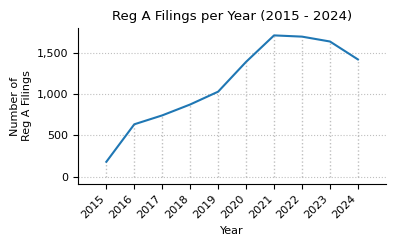

In [11]:
def plot_timeseries(ts, title):
    fig, ax = plt.subplots(figsize=(4, 2.5))
    ts["count"].plot(ax=ax, legend=False)
    ax.set_title(title)
    ax.set_xlabel("Year")
    ax.set_ylabel(f"Number of\n{form_name} Filings")
    ax.set_xticks(np.arange(min_year, max_year, 1))
    ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))
    ax.set_xlim(min_year - 1, max_year)
    ax.grid(axis="x")
    ax.set_axisbelow(True)
    plt.xticks(rotation=45, ha="right")

    for year in range(min_year, max_year, 1):
        year_y_max = ts.loc[year, "count"]
        ax.vlines(year, 0, year_y_max, linestyles=":", colors="grey", alpha=0.5, lw=1)

    plt.tight_layout()
    plt.show()


reg_a_filings = (
    structured_data_full_years.drop_duplicates(subset=["accessionNo"])
    .groupby(["year"])
    .size()
    .to_frame(name="count")
)

plot_timeseries(
    reg_a_filings,
    title=f"{form_name} Filings per Year ({min_year} - {max_year_full})",
)

In [12]:
count_formType = (
    structured_data_full_years.drop_duplicates(subset=["accessionNo"])
    .groupby(["formType"])
    .size()
    .sort_values(ascending=False)
    .to_frame(name="Count")
).rename_axis("Submission Type")
count_formType["Pct"] = (
    count_formType["Count"].astype(int) / count_formType["Count"].astype(int).sum()
).map("{:.0%}".format)
count_formType["Count"] = count_formType["Count"].map(lambda x: f"{x:,}")

print(f"{form_name} Disclosures by Submission Type ({min_year} - {max_year_full})")
count_formType

Reg A Disclosures by Submission Type (2015 - 2024)


,Count,Pct
Submission Type,,
1-A/A,"4,152",37%
1-A POS,"2,242",20%
1-A,"2,073",18%
1-K,"1,965",17%
1-A-W,428,4%
1-Z,311,3%
1-K/A,103,1%
1-Z/A,9,0%
1-Z-W,6,0%


In [13]:
form_counts_by_type_and_year = (
    structured_data_full_years.drop_duplicates(subset=["accessionNo"])
    .groupby(["year", "formType"])
    .size()
    .to_frame(name="count")
    .unstack(fill_value=0)
)

form_counts_by_type_and_year.loc["Total"] = form_counts_by_type_and_year.sum()
form_counts_by_type_and_year["Total"] = form_counts_by_type_and_year.sum(axis=1)


print(f"{form_name} counts from {min_year} to {max_year_full}.")
form_counts_by_type_and_year

Reg A counts from 2015 to 2024.


count                                                   Total
formType   1-A 1-A POS 1-A-W 1-A/A   1-K 1-K/A  1-Z 1-Z-W 1-Z/A       
year                                                                  
2015        53       3    10   107     0     0    5     0     0    178
2016       145      84    31   347    13     1    9     0     2    632
2017       125     148    22   353    59     7   24     1     1    740
2018       144     196    31   384    87     4   24     1     1    872
2019       204     198    41   444   109     9   22     0     0   1027
2020       255     291    45   606   155    11   25     0     0   1388
2021       360     324    55   684   244     7   30     0     4   1708
2022       352     368    56   462   356    33   64     2     0   1693
2023       264     374    64   394   458    20   59     1     0   1634
2024       171     256    73   371   484    11   49     1     1   1417
Total     2073    2242   428  4152  1965   103  311     6     9  11289

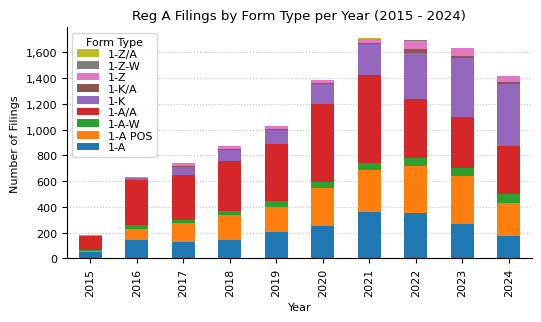

In [14]:
fig, ax = plt.subplots(figsize=(6, 3))
form_counts_by_type_and_year["count"].drop("Total").plot(
    kind="bar", stacked=True, ax=ax
)
ax.set_xlabel("Year")
ax.set_ylabel("Number of Filings")
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))
ax.grid(axis="x")
ax.set_axisbelow(True)
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    list(reversed(handles)),
    list(reversed(labels)),
    title="Form Type",
    labelspacing=0.15,
)
ax.set_title(
    f"{form_name} Filings by Form Type per Year ({min_year} - {max_year_full})"
)
plt.show()

In [15]:
counts_qtr_yr_piv = (
    structured_data_full_years.groupby(["year", "qtr"]).size().unstack().fillna(0)
).astype(int)

print(f"{form_name} counts by quarter from {min_year} to {max_year_full}.")
counts_qtr_yr_piv.T

Reg A counts by quarter from 2015 to 2024.


year,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
qtr,,,,,,,,,,
1,0,137,177,216,182,260,402,323,373,247
2,12,133,183,251,322,379,523,632,704,686
3,67,173,185,225,275,359,393,356,301,241
4,99,189,195,180,248,390,390,382,256,243


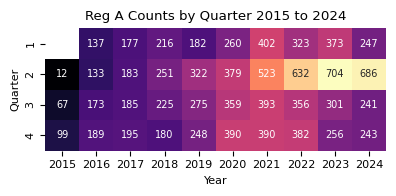

In [16]:
plt.figure(figsize=(4, 2))
sns.heatmap(
    counts_qtr_yr_piv.T,
    annot=True,  # Display the cell values
    fmt="d",  # Integer formatting
    cmap="magma",  # Color map
    cbar_kws={"label": "Count"},  # Colorbar label
    mask=counts_qtr_yr_piv.T == 0,  # Mask the cells with value 0
    cbar=False,
    annot_kws={"fontsize": 7},
)
plt.grid(False)
plt.title(f"{form_name} Counts by Quarter {min_year} to {max_year_full}")
plt.xlabel("Year")
plt.ylabel("Quarter")
plt.tight_layout()
plt.show()

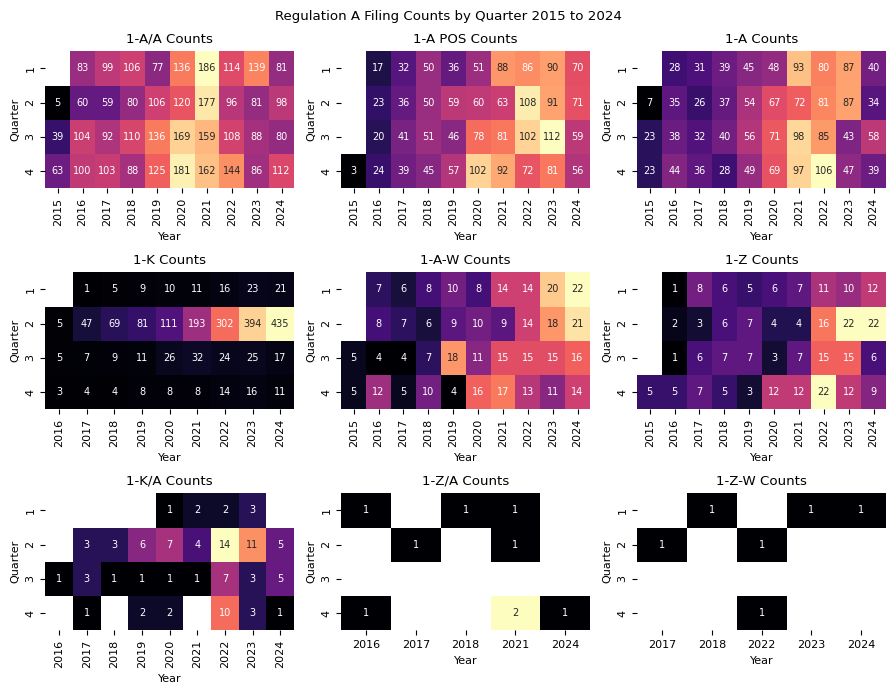

In [17]:
form_types = count_formType.index.tolist()

fig, axes = plt.subplots(3, 3, figsize=(9, 7))

cnt = 0
for formType in form_types:
    data = (
        structured_data_full_years[structured_data_full_years["formType"] == formType]
        .groupby(["year", "qtr"])
        .size()
        .unstack()
        .fillna(0)
        .astype(int)
        .reindex(columns=range(1, 5), fill_value=0)  # ensure all month are included
    )

    filing_name = formType
    # if data.sum().sum() < 100:
    #     continue

    ax = axes.flatten()[cnt]

    sns.heatmap(
        data.T,
        ax=ax,
        annot=True,  # Display the cell values
        fmt="d",  # Integer formatting
        cmap="magma",  # Color map
        cbar_kws={"label": "Count"},  # Colorbar label
        mask=data.T == 0,  # Mask the cells with value 0
        cbar=False,
        annot_kws={"fontsize": 7},
    )
    ax.grid(False)
    ax.set_title(f"{filing_name} Counts")
    ax.set_xlabel("Year")
    ax.set_ylabel("Quarter")

    cnt += 1

fig.suptitle(f"Regulation A Filing Counts by Quarter {min_year} to {max_year_full}")
plt.tight_layout()

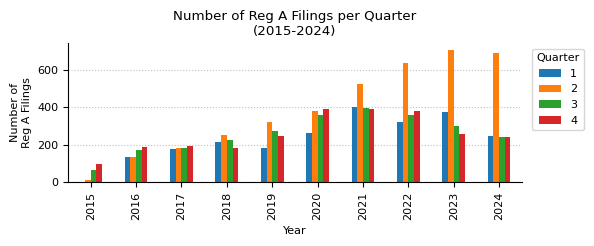

In [18]:
counts_qtr_yr = counts_qtr_yr_piv.stack().reset_index(name="count")

fig, ax = plt.subplots(figsize=(6, 2.5))
counts_qtr_yr_piv.plot(kind="bar", ax=ax, legend=True)
ax.legend(title="Quarter", loc="upper right", bbox_to_anchor=(1.15, 1))
ax.set_title(f"Number of {form_name} Filings per Quarter\n({min_year}-{max_year_full})")
ax.set_xlabel("Year")
ax.set_ylabel(f"Number of\n{form_name} Filings")
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))
ax.grid(axis="x")
ax.set_axisbelow(True)
plt.tight_layout()
plt.show()

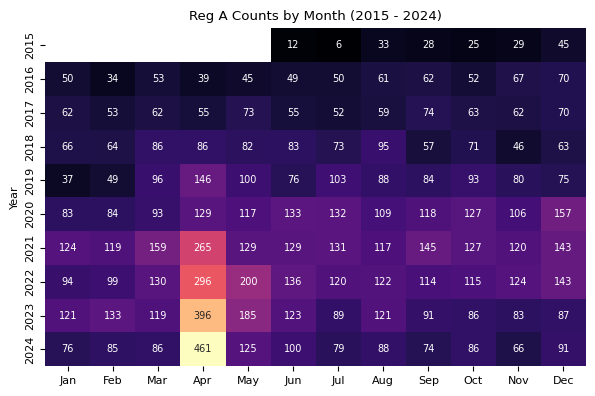

In [19]:
counts_month_yr_piv = (
    structured_data_full_years.groupby(["year", "month"]).size().unstack().fillna(0)
).astype(int)

plt.figure(figsize=(6, 4))
sns.heatmap(
    counts_month_yr_piv,
    annot=True,
    fmt="d",
    cmap="magma",
    cbar_kws={"label": "Count"},
    mask=counts_month_yr_piv == 0,
    cbar=False,
    annot_kws={"size": 7},
)
# convert x-labels to month names: 1 => Jan, 2 => Feb, etc.
plt.xticks(
    ticks=np.arange(0.5, 12.5, 1),
    labels=[pd.to_datetime(str(i), format="%m").strftime("%b") for i in range(1, 13)],
)
plt.grid(False)
plt.title(f"{form_name} Counts by Month ({min_year} - {max_year_full})")
plt.xlabel("")
plt.ylabel("Year")
plt.tight_layout()
plt.show()

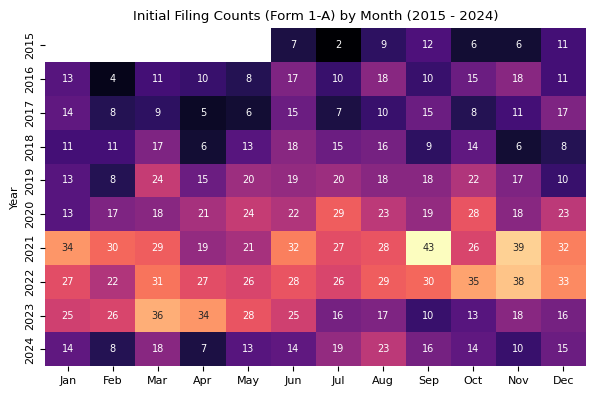

In [20]:
counts_initial_only_month_yr_piv = (
    structured_data_full_years[structured_data_full_years["formType"] == "1-A"]
    .groupby(["year", "month"])
    .size()
    .unstack()
    .fillna(0)
).astype(int)

plt.figure(figsize=(6, 4))
sns.heatmap(
    counts_initial_only_month_yr_piv,
    annot=True,
    fmt="d",
    cmap="magma",
    cbar_kws={"label": "Count"},
    mask=counts_initial_only_month_yr_piv == 0,
    cbar=False,
    annot_kws={"size": 7},
)
# convert x-labels to month names: 1 => Jan, 2 => Feb, etc.
plt.xticks(
    ticks=np.arange(0.5, 12.5, 1),
    labels=[pd.to_datetime(str(i), format="%m").strftime("%b") for i in range(1, 13)],
)
plt.grid(False)
plt.title(f"Initial Filing Counts (Form 1-A) by Month ({min_year} - {max_year_full})")
plt.xlabel("")
plt.ylabel("Year")
plt.tight_layout()
plt.show()

In [21]:
print(
    f"Descriptive statistics for Form 1-A filing counts by month from {min_year} to {max_year_full}."
)
month_stats = (
    counts_initial_only_month_yr_piv.loc[2004:]
    .describe(percentiles=[0.025, 0.975])
    .round(0)
    .astype(int)
)
month_stats

Descriptive statistics for Form 1-A filing counts by month from 2015 to 2024.


month,1,2,3,4,5,6,7,8,9,10,11,12
count,10,10,10,10,10,10,10,10,10,10,10,10
mean,16,13,19,14,16,20,17,19,18,18,18,18
std,10,10,11,11,9,7,9,7,11,9,12,9
min,0,0,0,0,0,7,2,9,9,6,6,8
2.5%,2,1,2,1,1,9,3,9,9,6,6,8
50%,14,10,18,12,16,18,18,18,16,14,18,16
97.5%,32,29,35,32,28,31,29,29,40,33,39,33
max,34,30,36,34,28,32,29,29,43,35,39,33


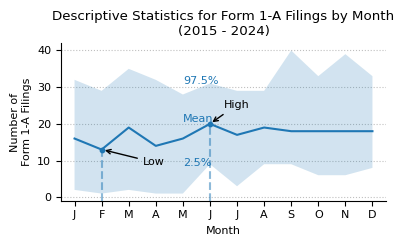

In [22]:
def plot_box_plot_as_line(
    data: pd.DataFrame,
    x_months=True,
    title="",
    x_label="",
    x_pos_mean_label=2,
    pos_labels=None,
    pos_high_low=None,
    y_label="",
    y_formatter=lambda x, p: "{:.0f}".format(int(x) / 1000),
    show_high_low_labels=True,
    show_inline_labels=True,
    show_bands=True,
    figsize=(4, 2.5),
    line_source="mean",
):
    fig, ax = plt.subplots(figsize=figsize)

    line_to_plot = data[line_source]
    lower_label = "2.5%"
    upper_label = "97.5%"
    lower = data[lower_label]
    upper = data[upper_label]

    line_to_plot.plot(ax=ax)

    if show_bands:
        ax.fill_between(line_to_plot.index, lower, upper, alpha=0.2)

    if x_months:
        ax.set_xlim(0.5, 12.5)
        ax.set_xticks(range(1, 13))
        ax.set_xticklabels(["J", "F", "M", "A", "M", "J", "J", "A", "S", "O", "N", "D"])

    ax.yaxis.set_major_formatter(mtick.FuncFormatter(y_formatter))
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    ax.set_title(title)

    ymin, ymax = ax.get_ylim()
    y_scale = ymax - ymin

    max_x = int(line_to_plot.idxmax())
    max_y = line_to_plot.max()
    min_x = int(line_to_plot.idxmin())
    min_y = line_to_plot.min()

    ax.axvline(
        max_x,
        ymin=0,
        ymax=((max_y - ymin) / (ymax - ymin)),
        linestyle="dashed",
        color="tab:blue",
        alpha=0.5,
    )
    ax.scatter(max_x, max_y, color="tab:blue", s=10)
    ax.axvline(
        min_x,
        ymin=0,
        ymax=((min_y - ymin) / (ymax - ymin)),
        linestyle="dashed",
        color="tab:blue",
        alpha=0.5,
    )
    ax.scatter(min_x, min_y, color="tab:blue", s=10)

    x_pos_mean_label_int = int(x_pos_mean_label)
    if show_inline_labels:
        mean_x = x_pos_mean_label
        mean_y = line_to_plot.iloc[x_pos_mean_label_int] * 1.02
        upper_x = x_pos_mean_label
        upper_y = upper.iloc[x_pos_mean_label_int]
        lower_x = x_pos_mean_label
        lower_y = lower.iloc[x_pos_mean_label_int] * 0.95

        if pos_labels:
            mean_x = pos_labels["mean"]["x"]
            mean_y = pos_labels["mean"]["y"]
            upper_x = pos_labels["upper"]["x"]
            upper_y = pos_labels["upper"]["y"]
            lower_x = pos_labels["lower"]["x"]
            lower_y = pos_labels["lower"]["y"]

        ax.text(mean_x, mean_y, "Mean", color="tab:blue", fontsize=8)
        ax.text(upper_x, upper_y, upper_label, color="tab:blue", fontsize=8)
        ax.text(lower_x, lower_y, lower_label, color="tab:blue", fontsize=8)

    if show_high_low_labels:
        high_x_origin = max_x
        high_y_origin = max_y
        high_x_label = high_x_origin + 0.5
        high_y_label = high_y_origin + 0.1 * y_scale
        if pos_high_low:
            high_x_label = pos_high_low["high"]["x"]
            high_y_label = pos_high_low["high"]["y"]
        ax.annotate(
            "High",
            (high_x_origin, high_y_origin),
            xytext=(high_x_label, high_y_label),
            arrowprops=dict(facecolor="black", arrowstyle="->"),
        )

        low_x_origin = min_x * 1.01
        low_y_origin = min_y
        low_x_label = low_x_origin + 1.5
        low_y_label = low_y_origin - 0.1 * y_scale
        if pos_high_low:
            low_x_label = pos_high_low["low"]["x"]
            low_y_label = pos_high_low["low"]["y"]
        ax.annotate(
            "Low",
            (low_x_origin, low_y_origin),
            xytext=(low_x_label, low_y_label),
            arrowprops=dict(facecolor="black", arrowstyle="->"),
        )

    ax.grid(axis="x")
    ax.set_axisbelow(True)

    plt.tight_layout()
    plt.show()


plot_box_plot_as_line(
    data=month_stats.T,
    title=f"Descriptive Statistics for Form 1-A Filings by Month\n({min_year} - {max_year_full})",
    x_label="Month",
    y_label="Number of\nForm 1-A Filings",
    y_formatter=lambda x, p: "{:.0f}".format(int(x)),
    x_pos_mean_label=5,
)

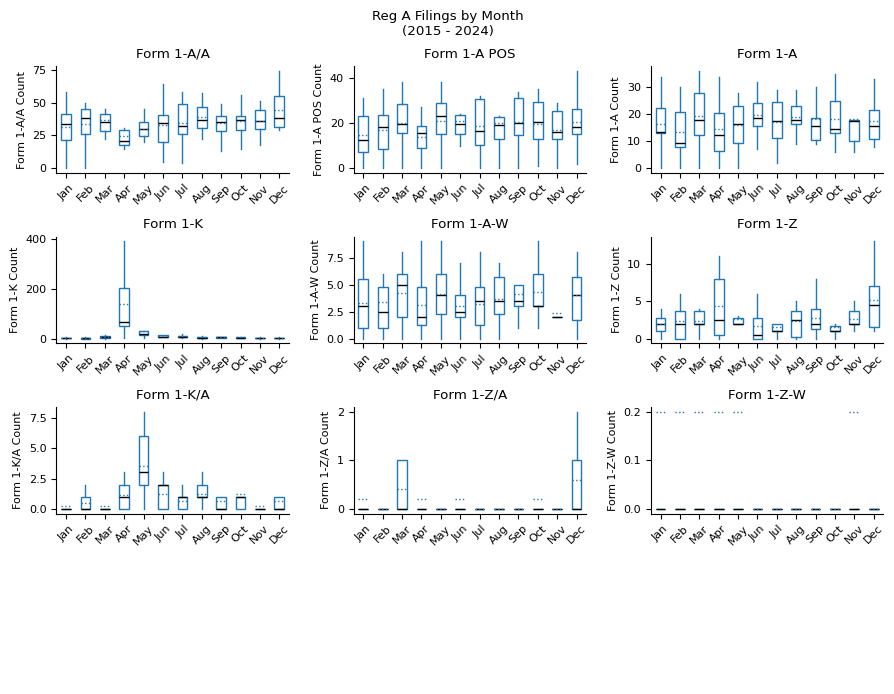

In [23]:
form_types = count_formType.index.tolist()

fig, axes = plt.subplots(4, 3, figsize=(9, 7))

cnt = 0
for formType in form_types:

    data = (
        structured_data_full_years[structured_data_full_years["formType"] == formType]
        .groupby(["year", "month"])
        .size()
        .unstack()
        .fillna(0)
        .reindex(columns=range(1, 13), fill_value=0)  # ensure all month are included
    )

    # if data.sum().sum() < 100:
    #     continue

    ax = axes.flatten()[cnt]
    cnt += 1
    try:
        data.boxplot(
            ax=ax,
            grid=False,
            showfliers=False,
            flierprops=dict(marker="o", markersize=3),
            patch_artist=True,
            boxprops=dict(facecolor="white", color="tab:blue"),
            showmeans=True,
            meanline=True,
            meanprops={"color": "tab:blue", "linestyle": ":"},
            medianprops={"color": "black"},
            capprops={"color": "none"},
        )

        ax.set_title(f"Form {formType}")
        ax.set_xlabel("")
        ax.set_ylabel(f"Form {formType} Count")
        xticklabels = [
            pd.to_datetime(str(x), format="%m").strftime("%b") for x in range(1, 13)
        ]
        ax.set_xticklabels(xticklabels)
        ax.tick_params(axis="x", rotation=45)
    except Exception as e:
        print(f"Error: {e}")

# disable the empty subplots
for i in range(cnt, 12):
    axes.flatten()[i].axis("off")

fig.suptitle(f"{form_name} Filings by Month\n({min_year} - {max_year_full})")
plt.tight_layout()
plt.show()

In [24]:
counts_per_month_by_formType = (
    structured_data[["year", "month", "accessionNo", "formType"]]
    .groupby(["year", "month", "formType"])
    .count()
    .rename(columns={"accessionNo": "count"})
    .pivot_table(
        index=["year", "month"],  # Rows
        columns="formType",  # Columns
        values="count",  # Values to fill
        fill_value=0,  # Replace NaN with 0
    )
    .astype(int)
    .reset_index()  # Make year and month normal columns
)

counts_per_month_by_formType

formType,year,month,1-A,1-A POS,1-A-W,1-A/A,1-K,1-K/A,1-Z,1-Z-W,1-Z/A
0,2015,6,7,0,0,5,0,0,0,0,0
1,2015,7,2,0,0,4,0,0,0,0,0
2,2015,8,9,0,2,22,0,0,0,0,0
3,2015,9,12,0,3,13,0,0,0,0,0
4,2015,10,6,1,3,15,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
112,2024,10,14,18,6,40,6,0,1,0,1
113,2024,11,10,17,4,33,1,0,1,0,0
114,2024,12,15,21,4,39,4,1,7,0,0
115,2025,1,10,12,5,26,5,2,2,0,0


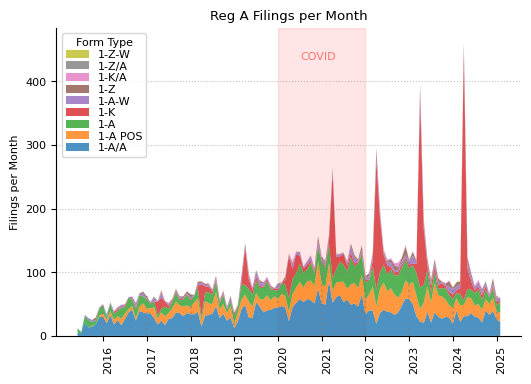

In [25]:
fix, ax = plt.subplots(figsize=(6, 4))

ax.stackplot(
    counts_per_month_by_formType["year"].astype(str)
    + "-"
    + counts_per_month_by_formType["month"].astype(str),
    *[counts_per_month_by_formType[ft] for ft in form_types],
    labels=[f"{ft}" for ft in form_types],
    alpha=0.8,
)
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    list(reversed(handles)),
    list(reversed(labels)),
    title="Form Type",
    labelspacing=0.15,
)

ax.set_title(f"{form_name} Filings per Month")
ax.set_ylabel("Filings per Month")
xticks = (
    counts_per_month_by_formType["year"].astype(str)
    + "-"
    + counts_per_month_by_formType["month"].astype(str)
)
ax.set_xticks([i for i, x in enumerate(xticks) if x.endswith("-1")])
ax.set_xticklabels(
    [label.get_text()[:4] for label in ax.get_xticklabels()], rotation=90, ha="left"
)

ax.grid(axis="y", linestyle=":", alpha=0.5)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
# draw vertical lines for each first month of the year, dotted, transparency 0.5,
# with height of the y value for the respective month
for year, month in counts_per_month_by_formType[["year", "month"]].values:
    if month == 1:
        ax.vlines(
            f"{year}-{month}",
            ymin=0,
            ymax=counts_per_month_by_formType[
                (counts_per_month_by_formType["year"] == year)
                & (counts_per_month_by_formType["month"] == month)
            ]
            .drop(columns=["year", "month"])
            .sum(axis=1),
            linestyle=":",
            alpha=0.5,
            color="grey",
        )

ax.axvspan("2020-1", "2022-1", alpha=0.1, color="red", zorder=-100)
ax.text(
    "2020-12",
    ax.get_ylim()[1] - 45,
    "COVID",
    horizontalalignment="center",
    verticalalignment="center",
    color="red",
    alpha=0.5,
)
plt.show()

In [26]:
counts_filedAtClass = (
    (
        structured_data.drop_duplicates(subset=["accessionNo"])
        .groupby(["filedAtClass"])
        .size()
        .sort_values(ascending=False)
        .to_frame(name="Count")
    )
    .rename_axis("Publication Time")
    .sort_values("Count", ascending=True)
)
counts_filedAtClass["Pct"] = (
    counts_filedAtClass["Count"].astype(int)
    / counts_filedAtClass["Count"].astype(int).sum()
).map("{:.0%}".format)
counts_filedAtClass["Count"] = counts_filedAtClass["Count"].map(lambda x: f"{x:,}")
counts_filedAtClass.index = (
    counts_filedAtClass.index.str.replace("preMarket", "Pre-Market (4:00 - 9:30 AM)")
    .str.replace("marketHours", "Market Hours (9:30 AM - 4:00 PM)")
    .str.replace("afterMarket", "After Market (4:00 - 8:00 PM)")
)
counts_filedAtClass = counts_filedAtClass.reindex(counts_filedAtClass.index[::-1])

print(
    f"{form_name} filing counts by pre-market, regular market hours,\nand after-market publication time ({min_year} - {max_year_full})."
)
counts_filedAtClass

Reg A filing counts by pre-market, regular market hours,
and after-market publication time (2015 - 2024).


,Count,Pct
Publication Time,,
After Market (4:00 - 8:00 PM),"4,912",43%
regularMarket,"4,731",41%
other,953,8%
Pre-Market (4:00 - 9:30 AM),815,7%


In [27]:
counts_dayOfWeek = (
    structured_data.drop_duplicates(subset=["accessionNo"])
    .groupby(["dayOfWeek"])
    .size()
    .to_frame(name="Count")
).rename_axis("Day of the Week")
counts_dayOfWeek["Pct"] = (
    counts_dayOfWeek["Count"].astype(int) / counts_dayOfWeek["Count"].astype(int).sum()
).map("{:.0%}".format)
counts_dayOfWeek["Count"] = counts_dayOfWeek["Count"].map(lambda x: f"{x:,}")

print(f"{form_name} filing counts by day of the week ({min_year} - {max_year}).")
counts_dayOfWeek.loc[["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]]

Reg A filing counts by day of the week (2015 - 2025).


,Count,Pct
Day of the Week,,
Monday,"2,191",19%
Tuesday,"2,052",18%
Wednesday,"2,100",18%
Thursday,"2,017",18%
Friday,"3,050",27%


## Offering Tier


Reg A filing count by Offering Tier (2015 - 2024)


,Count,Pct
Offering Tier,,
Tier2,"6,753",79%
Tier1,"1,816",21%


Reg A counts by Offering Tier and year from 2015 to 2024.


count       Total
Offering Tier Tier1 Tier2      
year                           
2015             82    81   163
2016            252   324   576
2017            177   449   626
2018            188   536   724
2019            174   672   846
2020            209   943  1152
2021            223  1145  1368
2022            198   984  1182
2023            161   871  1032
2024            134   664   798
2025             18    84   102
Total          1816  6753  8569

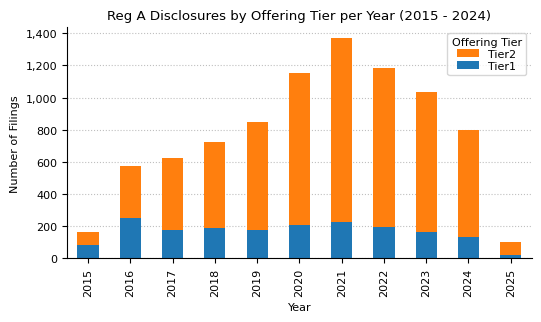

In [28]:
from IPython.display import display


def plot_count_by_category(df, category, title=None, pretty_name=None):
    if pretty_name is None:
        pretty_name = category
    count_formType = (
        df.drop_duplicates(subset=["accessionNo"])
        .groupby([category])
        .size()
        .sort_values(ascending=False)
        .to_frame(name="Count")
    ).rename_axis(pretty_name)
    count_formType["Pct"] = (
        count_formType["Count"].astype(int) / count_formType["Count"].astype(int).sum()
    ).map("{:.0%}".format)
    count_formType["Count"] = count_formType["Count"].map(lambda x: f"{x:,}")

    print(f"{form_name} filing count by {pretty_name} ({min_year} - {max_year_full})")
    display(count_formType)

    counts_by_category_month_year = (
        df.drop_duplicates(subset=["accessionNo"])
        .groupby(["year", category])
        .size()
        .to_frame(name="count")
        .rename_axis(["year", pretty_name])
        .unstack(fill_value=0)
    )

    counts_by_category_month_year.loc["Total"] = counts_by_category_month_year.sum()
    counts_by_category_month_year["Total"] = counts_by_category_month_year.sum(axis=1)

    print(
        f"{form_name} counts by {pretty_name} and year from {min_year} to {max_year_full}."
    )
    display(counts_by_category_month_year)

    fig, ax = plt.subplots(figsize=(6, 3))
    counts_by_category_month_year["count"].drop("Total").plot(
        kind="bar", stacked=True, ax=ax
    )
    ax.set_xlabel("Year")
    ax.set_ylabel("Number of Filings")
    ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))
    ax.grid(axis="x")
    ax.set_axisbelow(True)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        list(reversed(handles)),
        list(reversed(labels)),
        title=pretty_name,
        labelspacing=0.15,
    )
    ax.set_title(
        f"{form_name} Disclosures by {pretty_name} per Year ({min_year} - {max_year_full})"
    )
    plt.show()


plot_count_by_category(
    structured_data,
    "summaryInfo.indicateTier1Tier2Offering",
    pretty_name="Offering Tier",
)

Under Regulation A, Tier 1 allows companies to raise up to $20 million annually without audited financial statements but requires state-by-state compliance, while Tier 2 allows up to $75 million annually with audited financial statements, ongoing SEC reporting, investor limits, and exemption from state securities regulations.


## Offering amounts

In this section, we analyze the offering amount in the initial Form 1-A filings.


In [29]:
form_1a = structured_data_full_years[structured_data_full_years["formType"] == "1-A"]
form_1a["securitiesIssued"].info()

<class 'pandas.core.series.Series'>
Index: 2073 entries, 0 to 11310
Series name: securitiesIssued
Non-Null Count  Dtype 
--------------  ----- 
1388 non-null   object
dtypes: object(1)
memory usage: 32.4+ KB


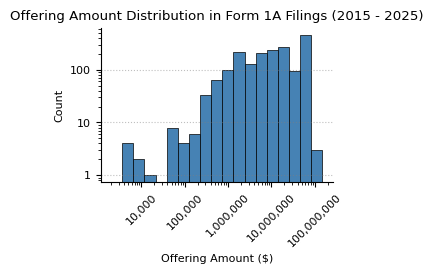

In [30]:
data = form_1a["summaryInfo.totalAggregateOffering"]
data = data[data > 1000]

# Define log-spaced bins
bin_edges = np.logspace(np.log10(min(data)), np.log10(max(data)), num=20)

fig, ax = plt.subplots(figsize=(3, 2))
ax.hist(
    data,
    bins=bin_edges,
    color="steelblue",
    edgecolor="black",
    linewidth=0.5,
)
ax.set_yscale("log")
ax.set_xscale("log")
ax.xaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))
ax.tick_params(axis="x", rotation=45)
ax.set_title(
    f"Offering Amount Distribution in Form 1A Filings ({min_year} - {max_year})"
)
ax.set_xlabel("Offering Amount ($)")
ax.set_ylabel("Count")
plt.show()

In [31]:
offering_amounts = (
    form_1a[["accessionNo", "fileNo", "year", "summaryInfo.totalAggregateOffering"]]
    .drop_duplicates(subset=["accessionNo", "fileNo"])
    .groupby(["year"])
    .sum()["summaryInfo.totalAggregateOffering"]
)

# offering_amounts.loc["Total"] = offering_amounts.sum()

print(f"Offering Amount in Form 1A filings from {min_year} to {max_year_full}.")
offering_amounts

Offering Amount in Form 1A filings from 2015 to 2024.


year
2015    1.088415e+09
2016    2.006582e+09
2017    2.827206e+09
2018    2.781807e+09
2019    4.068989e+09
2020    4.498605e+09
2021    7.562768e+09
2022    6.471967e+09
2023    4.821942e+09
2024    4.239667e+09
Name: summaryInfo.totalAggregateOffering, dtype: float64

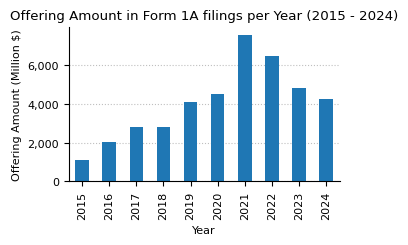

In [32]:
fig, ax = plt.subplots(figsize=(3.5, 2))
offering_amounts.apply(lambda x: x / 1e6).plot(kind="bar", stacked=True, ax=ax)
ax.set_xlabel("Year")
ax.set_ylabel("Offering Amount (Million $)")
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))
ax.grid(axis="x")
ax.set_axisbelow(True)
ax.set_title(
    f"Offering Amount in Form 1A filings per Year ({min_year} - {max_year_full})"
)
plt.show()

## Form 1-K Annual Report Dataset

In this section we analyze the selling progress of offered securities by year since initial offering of the securities based on information in the Form 1-K Annual Report filings.


In [33]:
form_1k_df = structured_data_full_years[structured_data_full_years["formType"] == "1-K"]
form_1k_df = form_1k_df.dropna(subset=["summaryInfo"])
form_1k_df = form_1k_df.explode("summaryInfo")
form_1k_df = pd.json_normalize(form_1k_df.to_dict(orient="records"))

In [34]:
selling_progress_data = form_1k_df[
    [
        "accessionNo",
        "fileNo",
        "filedAt",
        "summaryInfo.offeringCommenceDate",
        "summaryInfo.qualifiedSecuritiesSold",
        "summaryInfo.offeringSecuritiesSold",
    ]
].dropna()

In [35]:
# convert the date fields to datetime
selling_progress_data["summaryInfo.offeringCommenceDate"] = pd.to_datetime(
    selling_progress_data["summaryInfo.offeringCommenceDate"], errors="coerce"
).dt.date
selling_progress_data["filedAt"] = pd.to_datetime(
    selling_progress_data["filedAt"], utc=True
)
selling_progress_data["filedAt"] = selling_progress_data["filedAt"].dt.tz_convert(
    "US/Eastern"
)
selling_progress_data["filedAtDate"] = selling_progress_data["filedAt"].dt.date

selling_progress_data["timeOfferedDays"] = (
    selling_progress_data["summaryInfo.offeringCommenceDate"]
    - selling_progress_data["filedAtDate"]
).apply(lambda x: -x.days)

selling_progress_data["percentSold"] = (
    selling_progress_data["summaryInfo.offeringSecuritiesSold"]
    / selling_progress_data["summaryInfo.qualifiedSecuritiesSold"]
)

In [36]:
selling_progress_data

,accessionNo,fileNo,filedAt,summaryInfo.offeringCommenceDate,summaryInfo.qualifiedSecuritiesSold,summaryInfo.offeringSecuritiesSold,filedAtDate,timeOfferedDays,percentSold
0,0001214659-16-011078,24R-00009,2016-04-29 11:05:02-04:00,2015-11-20,3.009600e+07,16920576.0,2016-04-29,161,0.562220
1,0001376474-16-000679,24R-00013,2016-05-06 13:16:15-04:00,2016-02-04,6.000000e+06,0.0,2016-05-06,92,0.000000
2,0001644600-16-000142,24R-00007,2016-05-20 12:03:45-04:00,2016-01-21,2.000000e+07,0.0,2016-05-20,120,0.000000
3,0001644600-16-000171,24R-00022,2016-07-27 14:09:16-04:00,2016-03-22,6.432247e+06,1644018.0,2016-07-27,127,0.255590
4,0001477932-16-012593,24R-00024,2016-09-19 17:53:12-04:00,2015-02-03,2.500000e+07,1400000.0,2016-09-19,594,0.056000
...,...,...,...,...,...,...,...,...,...
482,0001410708-24-000005,24R-00915,2024-09-13 12:43:16-04:00,2023-08-18,1.500000e+09,0.0,2024-09-13,392,0.000000
483,0001925674-24-000004,24R-00957,2024-09-13 21:00:42-04:00,2023-12-11,2.500000e+07,4505096.0,2024-09-13,277,0.180204
484,0001096906-24-001940,24R-00529,2024-09-30 21:52:59-04:00,2021-09-27,1.221760e+07,135260.0,2024-09-30,1099,0.011071
485,0001062993-24-018101,24R-00694,2024-10-30 12:54:39-04:00,2022-07-26,5.000000e+06,2101819.0,2024-10-30,827,0.420364


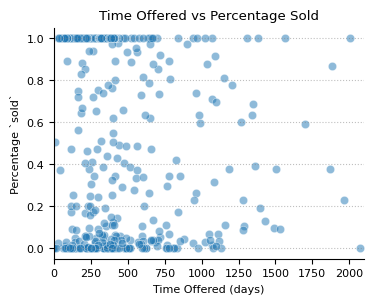

In [37]:
# scatter plot of the time offered vs the percentage of securities qualified
fig, ax = plt.subplots(figsize=(4, 3))
sns.scatterplot(
    x="timeOfferedDays",
    y="percentSold",
    data=selling_progress_data,
    alpha=0.5,
    ax=ax,
)
ax.set_xlabel("Time Offered (days)")
ax.set_ylabel("Percentage `sold`")
ax.set_title("Time Offered vs Percentage Sold")
ax.set_xlim(0, 2100)
plt.show()

## Form 1-Z Exit Reports


In [38]:
form_1z_df = structured_data_full_years[structured_data_full_years["formType"] == "1-Z"]
form_1z_suminfo = form_1z_df.dropna(subset=["summaryInfoOffering"])
form_1z_suminfo = form_1z_suminfo.explode("summaryInfoOffering")
form_1z_suminfo = pd.json_normalize(form_1z_suminfo.to_dict(orient="records"))
form_1z_suminfo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Columns: 144 entries, id to summaryInfoOffering.crdNumberBrokerDealer
dtypes: datetime64[ns, US/Eastern](1), float64(110), int64(4), object(29)
memory usage: 303.9+ KB


In [39]:
aggregated_value_df = form_1z_suminfo[
    [
        "accessionNo",
        "fileNo",
        "filedAt",
        "summaryInfoOffering.offeringCommenceDate",
        "summaryInfoOffering.offeringSecuritiesQualifiedSold",
        "summaryInfoOffering.offeringSecuritiesSold",
        "summaryInfoOffering.pricePerSecurity",
        "summaryInfoOffering.findersFees",
        "summaryInfoOffering.legalFees",
        "summaryInfoOffering.auditorFees",
        "summaryInfoOffering.blueSkyFees",
        "summaryInfoOffering.promotersFees",
        "summaryInfoOffering.salesCommissionsFee",
        "summaryInfoOffering.underwriterFees",
    ]
]

In [40]:
# plot the distribution of the offering amount
securities_sold = aggregated_value_df["summaryInfoOffering.offeringSecuritiesSold"]
price_per_share = aggregated_value_df["summaryInfoOffering.pricePerSecurity"]
aggregated_value_df.loc[:, "aggregatedValue"] = securities_sold * price_per_share
aggregated_value_df.dropna(subset=["aggregatedValue"], inplace=True)
aggregated_value_df = aggregated_value_df.loc[
    aggregated_value_df["aggregatedValue"] > 1000
]
aggregated_value_df.head

/var/folders/83/7b5245js685cr2ybfzjf9yq00000gn/T/ipykernel_47707/1359918954.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aggregated_value_df.loc[:, "aggregatedValue"] = securities_sold * price_per_share
/var/folders/83/7b5245js685cr2ybfzjf9yq00000gn/T/ipykernel_47707/1359918954.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aggregated_value_df.dropna(subset=["aggregatedValue"], inplace=True)


<bound method NDFrame.head of               accessionNo     fileNo                   filedAt  \
2    0001144204-15-065207  24R-00003 2015-11-13 14:20:10-05:00   
3    0001389049-15-000003  24R-00004 2015-11-19 18:03:09-05:00   
4    0001144204-15-073653  24R-00003 2015-12-31 17:00:02-05:00   
5    0001506275-16-000004  24R-00006 2016-01-28 15:58:00-05:00   
6    0001354488-16-007263  24R-00014 2016-05-06 19:16:18-04:00   
..                    ...        ...                       ...   
265  0001683168-24-008477  24R-00975 2024-12-03 15:35:28-05:00   
266  0001683168-24-008572  24R-00976 2024-12-09 15:38:10-05:00   
267  0001214659-24-020072  24R-00977 2024-12-09 16:11:33-05:00   
268  0001683168-24-008783  24R-00508 2024-12-17 14:17:32-05:00   
269  0001829126-24-008673  24R-00889 2024-12-31 17:27:40-05:00   

    summaryInfoOffering.offeringCommenceDate  \
2                                 09-02-2015   
3                                 01-30-2015   
4                                

In [41]:
# convert the date fields to datetime
aggregated_value_df["summaryInfoOffering.offeringCommenceDate"] = pd.to_datetime(
    aggregated_value_df["summaryInfoOffering.offeringCommenceDate"], errors="coerce"
).dt.date
aggregated_value_df["filedAt"] = pd.to_datetime(
    aggregated_value_df["filedAt"], utc=True
)
aggregated_value_df["filedAt"] = aggregated_value_df["filedAt"].dt.tz_convert(
    "US/Eastern"
)
aggregated_value_df["filedAtDate"] = aggregated_value_df["filedAt"].dt.date

aggregated_value_df = aggregated_value_df.dropna(
    subset=["filedAtDate", "summaryInfoOffering.offeringCommenceDate"]
)

aggregated_value_df.loc[:, "timeOfferedDays"] = (
    aggregated_value_df["summaryInfoOffering.offeringCommenceDate"]
    - aggregated_value_df["filedAtDate"]
).apply(lambda x: -x.days)

aggregated_value_df.loc[:, "percentSold"] = (
    100
    * aggregated_value_df["summaryInfoOffering.offeringSecuritiesSold"]
    / aggregated_value_df["summaryInfoOffering.offeringSecuritiesQualifiedSold"]
)

aggregated_value_df.loc[:, "raisedPerYear"] = aggregated_value_df["aggregatedValue"] / (
    aggregated_value_df["timeOfferedDays"] / 365
)

aggregated_value_df = aggregated_value_df.dropna(subset=["raisedPerYear"])

In [42]:
aggregated_value_df

,accessionNo,fileNo,filedAt,summaryInfoOffering.offeringCommenceDate,summaryInfoOffering.offeringSecuritiesQualifiedSold,summaryInfoOffering.offeringSecuritiesSold,summaryInfoOffering.pricePerSecurity,summaryInfoOffering.findersFees,summaryInfoOffering.legalFees,summaryInfoOffering.auditorFees,summaryInfoOffering.blueSkyFees,summaryInfoOffering.promotersFees,summaryInfoOffering.salesCommissionsFee,summaryInfoOffering.underwriterFees,aggregatedValue,filedAtDate,timeOfferedDays,percentSold,raisedPerYear
2,0001144204-15-065207,24R-00003,2015-11-13 14:20:10-05:00,2015-09-02,5.450000e+05,505000.0,10.0000,NaN,508000.0,30000.0,6000.0,NaN,NaN,NaN,5.050000e+06,2015-11-13,72,92.660550,2.560069e+07
3,0001389049-15-000003,24R-00004,2015-11-19 18:03:09-05:00,2015-01-30,6.000000e+04,60000.0,25.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.500000e+06,2015-11-19,293,100.000000,1.868601e+06
4,0001144204-15-073653,24R-00003,2015-12-31 17:00:02-05:00,2015-10-30,1.453000e+06,1303000.0,10.0000,NaN,16000.0,4000.0,3000.0,NaN,NaN,NaN,1.303000e+07,2015-12-31,62,89.676531,7.670887e+07
5,0001506275-16-000004,24R-00006,2016-01-28 15:58:00-05:00,2014-12-29,4.613422e+06,429000.0,1000.0000,0.0,17898.0,0.0,4396.0,0.0,0.0,0.0,4.290000e+08,2016-01-28,395,9.298954,3.964177e+08
6,0001354488-16-007263,24R-00014,2016-05-06 19:16:18-04:00,2016-03-02,1.023110e+06,885345.0,12.2200,NaN,150000.0,25000.0,NaN,NaN,NaN,NaN,1.081892e+07,2016-05-06,65,86.534683,6.075237e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,0001683168-24-008477,24R-00975,2024-12-03 15:35:28-05:00,2023-08-29,1.000000e+08,9000000.0,0.0100,NaN,15000.0,NaN,1500.0,NaN,NaN,NaN,9.000000e+04,2024-12-03,462,9.000000,7.110390e+04
266,0001683168-24-008572,24R-00976,2024-12-09 15:38:10-05:00,2023-08-07,2.000000e+09,665000000.0,0.0002,NaN,15000.0,NaN,1500.0,NaN,NaN,NaN,1.330000e+05,2024-12-09,490,33.250000,9.907143e+04
267,0001214659-24-020072,24R-00977,2024-12-09 16:11:33-05:00,2023-09-11,1.000000e+07,15117666.0,0.0053,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.012363e+04,2024-12-09,455,151.176660,6.427500e+04
268,0001683168-24-008783,24R-00508,2024-12-17 14:17:32-05:00,2023-09-26,2.083333e+07,85849.0,3.6000,NaN,90000.0,46500.0,NaN,NaN,NaN,3090.0,3.090564e+05,2024-12-17,448,0.412075,2.517982e+05


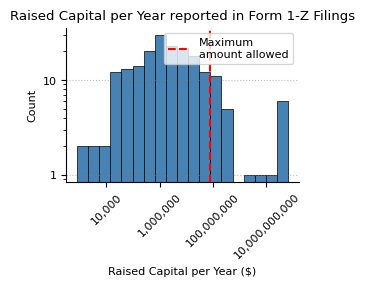

In [43]:
def plot_histogram(data, title, x_label, y_label, log_scale=True):
    if log_scale:
        bin_edges = np.logspace(np.log10(min(data)), np.log10(max(data)), num=20)
    else:
        bin_edges = 20
    fig, ax = plt.subplots(figsize=(3, 2))
    ax.hist(
        data,
        bins=bin_edges,
        color="steelblue",
        edgecolor="black",
        linewidth=0.5,
    )
    if log_scale:
        ax.set_yscale("log")
        ax.set_xscale("log")
        ax.xaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))
        ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))
        ax.tick_params(axis="x", rotation=45)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

    return fig, ax


fig, ax = plot_histogram(
    aggregated_value_df["raisedPerYear"],
    "Raised Capital per Year reported in Form 1-Z Filings",
    "Raised Capital per Year ($)",
    "Count",
)

ax.axvline(75_000_000, color="red", linestyle="--", label="Maximum\namount allowed")
ax.legend()
plt.show()

There are some outliers here probably cause by errors in the reporting.
The maximum allowed amount to be raised per year under Regulation A is $75 million.
Let's exclude all filings which report a higher number and visualize the total amount raised.


In [44]:
aggregated_value_df = aggregated_value_df[
    aggregated_value_df["raisedPerYear"] < 75_000_000
]

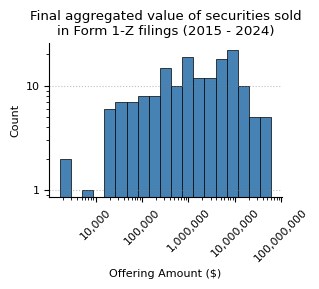

In [45]:
fig, ax = plot_histogram(
    aggregated_value_df["aggregatedValue"],
    f"Final aggregated value of securities sold\nin Form 1-Z filings ({min_year} - {max_year_full})",
    "Offering Amount ($)",
    "Count",
)

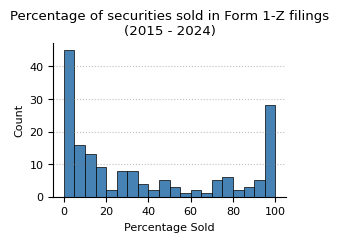

In [46]:
fig, ax = plot_histogram(
    aggregated_value_df["percentSold"][
        aggregated_value_df["percentSold"].between(0, 100)
    ],
    f"Percentage of securities sold in Form 1-Z filings\n({min_year} - {max_year_full})",
    "Percentage Sold",
    "Count",
    log_scale=False,
)

In [47]:
aggregated_value_df

,accessionNo,fileNo,filedAt,summaryInfoOffering.offeringCommenceDate,summaryInfoOffering.offeringSecuritiesQualifiedSold,summaryInfoOffering.offeringSecuritiesSold,summaryInfoOffering.pricePerSecurity,summaryInfoOffering.findersFees,summaryInfoOffering.legalFees,summaryInfoOffering.auditorFees,summaryInfoOffering.blueSkyFees,summaryInfoOffering.promotersFees,summaryInfoOffering.salesCommissionsFee,summaryInfoOffering.underwriterFees,aggregatedValue,filedAtDate,timeOfferedDays,percentSold,raisedPerYear
2,0001144204-15-065207,24R-00003,2015-11-13 14:20:10-05:00,2015-09-02,5.450000e+05,5.050000e+05,10.0000,NaN,508000.0,30000.0,6000.0,NaN,NaN,NaN,5.050000e+06,2015-11-13,72,92.660550,2.560069e+07
3,0001389049-15-000003,24R-00004,2015-11-19 18:03:09-05:00,2015-01-30,6.000000e+04,6.000000e+04,25.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.500000e+06,2015-11-19,293,100.000000,1.868601e+06
6,0001354488-16-007263,24R-00014,2016-05-06 19:16:18-04:00,2016-03-02,1.023110e+06,8.853450e+05,12.2200,NaN,150000.0,25000.0,NaN,NaN,NaN,NaN,1.081892e+07,2016-05-06,65,86.534683,6.075237e+07
7,0001621388-16-000004,24R-00015,2016-05-16 12:17:55-04:00,2015-04-01,1.000000e+10,1.015000e+09,0.0100,0.0,38991.0,0.0,2050.0,NaN,0.0,0.0,1.015000e+07,2016-05-16,411,10.150000,9.013990e+06
8,0001104659-16-131746,24R-00020,2016-07-08 16:03:16-04:00,2015-11-30,1.538462e+06,1.184726e+06,6.5000,NaN,113274.0,22880.0,5000.0,NaN,NaN,NaN,7.700719e+06,2016-07-08,221,77.007167,1.271838e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,0001683168-24-008477,24R-00975,2024-12-03 15:35:28-05:00,2023-08-29,1.000000e+08,9.000000e+06,0.0100,NaN,15000.0,NaN,1500.0,NaN,NaN,NaN,9.000000e+04,2024-12-03,462,9.000000,7.110390e+04
266,0001683168-24-008572,24R-00976,2024-12-09 15:38:10-05:00,2023-08-07,2.000000e+09,6.650000e+08,0.0002,NaN,15000.0,NaN,1500.0,NaN,NaN,NaN,1.330000e+05,2024-12-09,490,33.250000,9.907143e+04
267,0001214659-24-020072,24R-00977,2024-12-09 16:11:33-05:00,2023-09-11,1.000000e+07,1.511767e+07,0.0053,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.012363e+04,2024-12-09,455,151.176660,6.427500e+04
268,0001683168-24-008783,24R-00508,2024-12-17 14:17:32-05:00,2023-09-26,2.083333e+07,8.584900e+04,3.6000,NaN,90000.0,46500.0,NaN,NaN,NaN,3090.0,3.090564e+05,2024-12-17,448,0.412075,2.517982e+05


/var/folders/83/7b5245js685cr2ybfzjf9yq00000gn/T/ipykernel_47707/2491679412.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aggregated_value_df.loc[:, "totalFees"] = aggregated_value_df[
/var/folders/83/7b5245js685cr2ybfzjf9yq00000gn/T/ipykernel_47707/2491679412.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aggregated_value_df.loc[:, "feePercentage"] = (


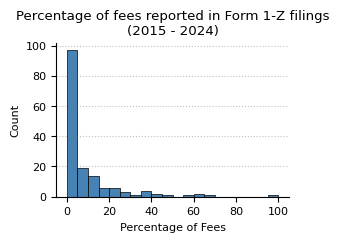

In [48]:
# calculate the total fees
fees = [
    "findersFees",
    "legalFees",
    "auditorFees",
    "blueSkyFees",
    "promotersFees",
    "salesCommissionsFee",
    "underwriterFees",
]
aggregated_value_df.loc[:, "totalFees"] = aggregated_value_df[
    [f"summaryInfoOffering.{fee}" for fee in fees]
].sum(axis=1)
aggregated_value_df["totalFees"]

aggregated_value_df.loc[:, "feePercentage"] = (
    100 * aggregated_value_df["totalFees"] / aggregated_value_df["aggregatedValue"]
)

fig, ax = plot_histogram(
    aggregated_value_df["feePercentage"][
        aggregated_value_df["feePercentage"].between(0, 100)
    ],
    f"Percentage of fees reported in Form 1-Z filings\n({min_year} - {max_year_full})",
    "Percentage of Fees",
    "Count",
    log_scale=False,
)

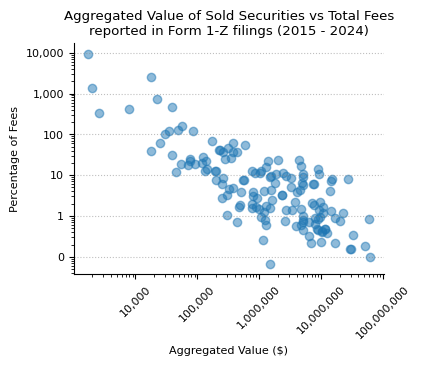

In [49]:
# scatter plot of the total fees vs the aggregated value
fig, ax = plt.subplots(figsize=(4, 3))
ax.scatter(
    aggregated_value_df["aggregatedValue"],
    aggregated_value_df["feePercentage"],
    alpha=0.5,
)
ax.set_xlabel("Aggregated Value ($)")
ax.set_ylabel("Percentage of Fees")
ax.set_title(
    f"Aggregated Value of Sold Securities vs Total Fees\nreported in Form 1-Z filings ({min_year} - {max_year_full})"
)
ax.set_xscale("log")
ax.set_yscale("log")
ax.xaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))
ax.tick_params(axis="x", rotation=45)
plt.show()